# Installs / Imports

In [ ]:
# install conda (this restarts the colab kernel -- wait until restart before running subsequent blocks)

!pip install condacolab
import condacolab
condacolab.install_miniconda()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py38_4.12.0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
!pip install geopandas

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd
import fiona
import numpy as np

from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
plt.rcParams['figure.dpi'] = 200

# Data downloading

In [ ]:
# download flood risk data from https://catalog.data.gov/dataset/national-flood-hazard-layer-nfhl

!wget https://gis.fema.gov/NFHL/NFHL_Key_Layers.gdb.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-01-26 22:45:33--  https://gis.fema.gov/NFHL/NFHL_Key_Layers.gdb.zip
Resolving gis.fema.gov (gis.fema.gov)... 104.100.179.225, 2a02:26f0:c900:29c::12b4, 2a02:26f0:c900:294::12b4
Connecting to gis.fema.gov (gis.fema.gov)|104.100.179.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14521973992 (14G) [application/zip]
Saving to: ‘NFHL_Key_Layers.gdb.zip’

NFHL_Key_Layers.gdb 100%[===================>]  13.52G  13.0MB/s    in 12m 39s 

2023-01-26 22:58:13 (18.2 MB/s) - ‘NFHL_Key_Layers.gdb.zip’ saved [14521973992/14521973992]



In [ ]:
# unzip data

!unzip NFHL_Key_Layers.gdb.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  NFHL_Key_Layers.gdb.zip
  inflating: NFHL_Key_Layers.gdb/a00000001.freelist  
  inflating: NFHL_Key_Layers.gdb/a00000001.gdbindexes  
  inflating: NFHL_Key_Layers.gdb/a00000001.gdbtable  
  inflating: NFHL_Key_Layers.gdb/a00000001.gdbtablx  
  inflating: NFHL_Key_Layers.gdb/a00000001.TablesByName.atx  
  inflating: NFHL_Key_Layers.gdb/a00000002.gdbtable  
  inflating: NFHL_Key_Layers.gdb/a00000002.gdbtablx  
  inflating: NFHL_Key_Layers.gdb/a00000003.gdbindexes  
  inflating: NFHL_Key_Layers.gdb/a00000003.gdbtable  
  inflating: NFHL_Key_Layers.gdb/a00000003.gdbtablx  
  inflating: NFHL_Key_Layers.gdb/a00000004.CatItemsByPhysicalName.atx  
  inflating: NFHL_Key_Layers.gdb/a00000004.CatItemsByType.atx  
  inflating: NFHL_Key_Layers.gdb/a00000004.FDO_UUID.atx  
  inflating: NFHL_Key_Layers.gdb/a00000004.freelist  
  inflating: NFHL_Key_Layers.gdb/a00000004.gdbindexes  
  inflating:

In [ ]:
# get US states shape file -- this may be used to only load the data from Florida, for example

!wget https://www.weather.gov/source/gis/Shapefiles/County/s_08mr23.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
wget: /usr/local/lib/libuuid.so.1: no version information available (required by wget)
--2023-01-26 23:55:33--  https://www.weather.gov/source/gis/Shapefiles/County/s_08mr23.zip
Resolving www.weather.gov (www.weather.gov)... 173.223.112.11, 2a02:26f0:6d00:69d::116, 2a02:26f0:6d00:6a7::116
Connecting to www.weather.gov (www.weather.gov)|173.223.112.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20805339 (20M) [application/zip]
Saving to: ‘s_08mr23.zip’

s_08mr23.zip        100%[===================>]  19.84M  66.0MB/s    in 0.3s    

2023-01-26 23:55:33 (66.0 MB/s) - ‘s_08mr23.zip’ saved [20805339/20805339]



In [ ]:
!unzip s_08mr23.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  s_08mr23.zip
  inflating: s_08mr23.dbf            
  inflating: s_08mr23.prj            
  inflating: s_08mr23.shp            
  inflating: s_08mr23.shx            


# Data visualization

In [ ]:
fiona.listlayers('/content/NFHL_Key_Layers.gdb/')

# the ArcGis map (https://www.arcgis.com/home/item.html?id=2b245b7f816044d7a779a61a5844be23#overview) uses S_FLD_HAZ_AR, but according to the documentation
# (https://dnr.wi.gov/topic/floodplains/documents/GIS_Submittal_Format.pdf) L_XS_ELEV has more flood categories ...

['S_BFE',
 'S_XS',
 'S_FLD_HAZ_AR',
 'S_GEN_STRUCT',
 'S_FIRM_PAN',
 'L_XS_ELEV',
 'S_LOMR',
 'S_LiMWA',
 'STUDY_INFO']

In [ ]:
# create a custom square polygon around a latlon point and use that as a mask prior to loading data. This does work, but takes the same time (1.5 min) for buffer = 1 and buffer = 0.001
# may be better to use a larger buffer of ~ 1 around one of the supplied latlon values

lat, lon = 32.766259, -79.864261
buffer = 1

lat_point_list = [lat - buffer, lat + buffer, lat - buffer, lat + buffer]
lon_point_list = [lon - buffer, lon + buffer, lon + buffer, lon - buffer]

# creates a square polygon centred on the latlon point
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom]) 

image = gpd.read_file('/content/NFHL_Key_Layers.gdb/', layer = "S_FLD_HAZ_AR", ignore_fields = ['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 
       'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
       'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'Shape_Length',
       'Shape_Area', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID'],
       mask = polygon)

In [ ]:
# this block of code works, but uses a massive amount of RAM and seems to crash looking at states like Florida

states = gpd.read_file("/content/s_08mr23.shp")

lat, lon = 32.766259, -79.864261

bbox = (
    lat - 1, lon - 1, lat + 1, lon + 1
)

image = gpd.read_file('/content/NFHL_Key_Layers.gdb/', layer = "S_FLD_HAZ_AR", ignore_fields = ['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 
       'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
       'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'Shape_Length',
       'Shape_Area', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID'],
       mask = states[states.NAME == "Florida"]) # this is the flood hazard layer, but too big to load into RAM, so drop a bunch of columns and filter by Florida


In [ ]:
states

,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.826760,32.793540,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.439200,34.899770,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.372150,-14.264860,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."
3,AZ,Arizona,04,-111.664570,34.293230,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
4,CA,California,06,-119.608180,37.245370,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."
5,CO,Colorado,08,-105.547830,38.998550,"POLYGON ((-106.87560 41.00301, -106.85850 41.0..."
6,CT,Connecticut,09,-72.726230,41.621960,"MULTIPOLYGON (((-73.62247 40.98430, -73.62209 ..."
7,DC,District of Columbia,11,-77.014640,38.909320,"MULTIPOLYGON (((-77.03097 38.80826, -77.03110 ..."
8,DE,Delaware,10,-75.505920,38.995590,"MULTIPOLYGON (((-75.22731 38.58854, -75.22744 ..."
9,FL,Florida,12,-82.509340,28.674020,"MULTIPOLYGON (((-81.96339 24.52110, -81.96374 ..."


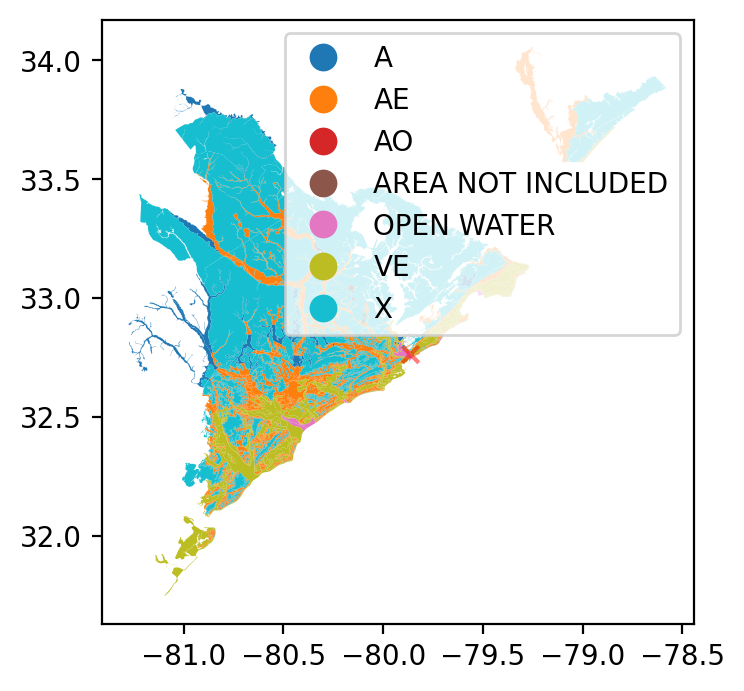

In [ ]:
image.plot(column = "FLD_ZONE", legend = True)
plt.scatter(lon, lat, marker = "x", c = "red", alpha = 0.5)

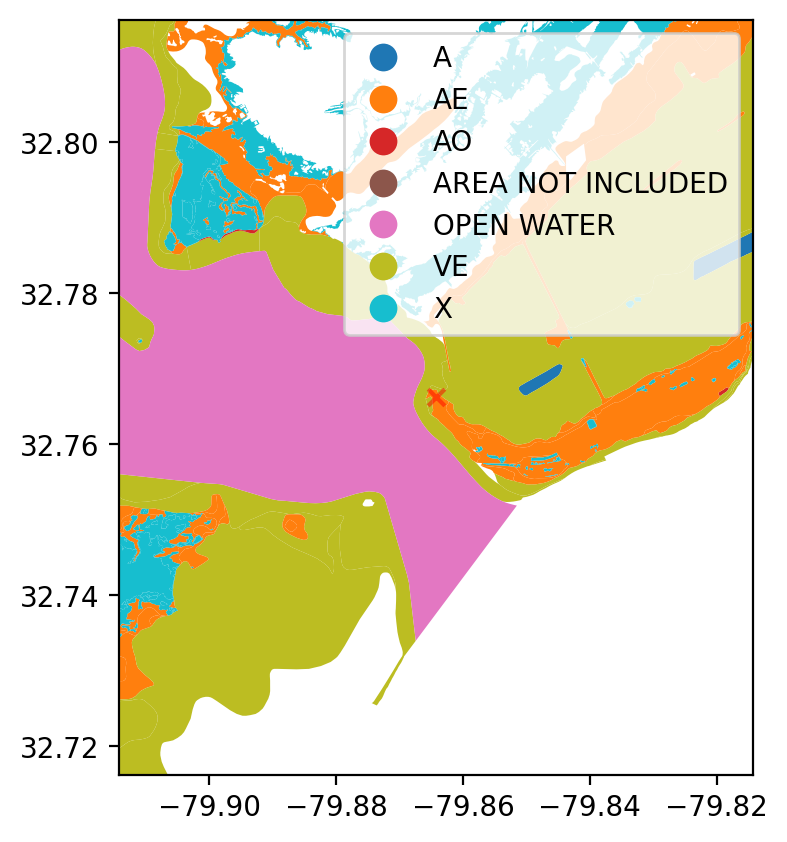

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
image.plot(column = "FLD_ZONE", ax = ax, legend = True)
ax.set_xlim(lon - 0.05, lon + 0.05)
ax.set_ylim(lat - 0.05, lat + 0.05)
plt.scatter(lon, lat, marker = "x", c = "red", alpha = 0.5)

In [ ]:
image.columns

Index(['FLD_ZONE', 'ZONE_SUBTY', 'geometry'], dtype='object')

In [ ]:
image.head()

,FLD_ZONE,ZONE_SUBTY,geometry
0,VE,None,"MULTIPOLYGON (((-79.86448 32.76358, -79.86500 ..."
1,AE,None,"MULTIPOLYGON (((-79.82636 32.76996, -79.82646 ..."
2,VE,None,"MULTIPOLYGON (((-79.73616 32.82291, -79.73565 ..."


In [ ]:
image[image.geometry.contains(Point(lon, lat))] # note lat and lon have swapped places

,FLD_ZONE,ZONE_SUBTY,geometry
1,AE,None,"MULTIPOLYGON (((-79.82636 32.76996, -79.82646 ..."


In [ ]:
# psuedocode:
# 1. pick a random value in the latlon list, produce an image with a buffer of 1 around that latlon
# 2. for each value in the latlon list, if the image contains that latlon value then append the flood risk value and remove latlon from the list
# 3. repeat 1 and 2 until the latlon list is empty, i.e. all latlon values have an assigned flood risk value


# Get EF value from a given lat / long

# Repeat above but for Haiti

# Turn it into a useable function